In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd

In [27]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,inspect

In [29]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [38]:
####  Extra EDA
# need to understand the table first
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('measurement')
print("Columns of table measurement")
for c in columns:
    print(c['name'], c["type"])
## seeing and understanding the data 
engine.execute('SELECT * FROM measurement limit 5 ').fetchall()


Columns of table measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [36]:
## Extra  EDA
### need to understand the table first
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('station')
print("Columns of table station")
for c in columns:
    print(c['name'], c["type"])

## seeing and understanding the data 
engine.execute('SELECT * FROM station limit 5').fetchall()


Columns of table station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [19]:
## Get the latest date ORM way
#import datetime as dt 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date[0])

query_date = dt.datetime.strptime(latest_date[0],"%Y-%m-%d").date() - dt.timedelta(days=365)
print(query_date)

2017-08-23
2016-08-23


In [42]:
### Perform a query to retrieve the data and precipitation scores
stmt = session.query(Measurement.date ,Measurement.prcp)\
    .filter(Measurement.date>=query_date).statement


df_prcp = pd.read_sql(stmt,session.bind)

df_prcp.set_index('date',drop=True)
df_prcp.rename(columns={"prcp": "precipitation"},inplace=True)
print(df_prcp.columns)

print(df_prcp.head(3))

Index(['date', 'precipitation'], dtype='object')
         date  precipitation
0  2016-08-23           0.00
1  2016-08-24           0.08
2  2016-08-25           0.08


Text(0.5,-1.34,'Date')

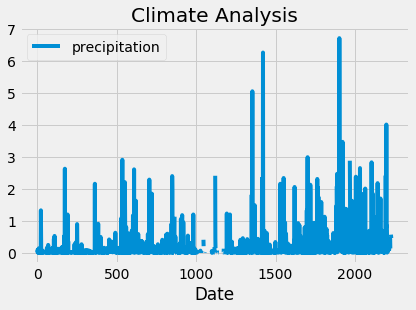

In [44]:
# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.plot()
plt.tight_layout()
plt.title("Climate Analysis")
plt.xlabel("Date")

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
stations_count= session.query(Measurement).group_by(Measurement.station).count()

print("There are {} stations in dataset".format(stations_count))

There are 9 stations in dataset


In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by((func.count(Measurement.station).desc())).all()
print(results)

most_active_station = [result for result in results[0]][0]

print("Most active station is {}".format(most_active_station))

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
Most active station is USC00519281


In [54]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station = 'USC00519281'
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
temp_averages = session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).all()
temp_averages

[(54.0, 85.0, 71.66378066378067)]

In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#stmt = session.query(Measurement.date ,Measurement.prcp).statement
stmt2 = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
        filter(Measurement.date>='2016-08-23').filter(Measurement.date <= '2017-08-23').statement

df_temps = pd.read_sql(stmt2,session.bind)
print(df_temps.head(3))


   tobs
0  77.0
1  77.0
2  80.0


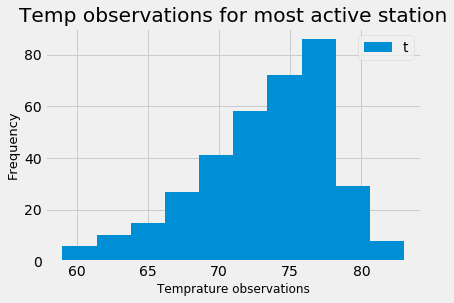

In [56]:
#fig=plt.figure(figsize=(10,20))
df_temps.hist(column='tobs')
plt.xlabel("Temprature observations",fontsize=12)
plt.ylabel("Frequency",fontsize=13)
plt.title("Temp observations for most active station")
plt.legend('tobs',loc ='best')



In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [59]:
start_date = '2012-03-05'
results = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).filter(Measurement.date >= start_date).all()

    # Convert list of tuples into normal list
all_temps = list(np.ravel(results))
all_temps

[53.0, 73.44226080531955, 87.0]

In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2016-08-23', '2017-08-23')

tmin = [temp[0] for temp in temps[:1]]
tavg = [temp[1] for temp in temps[:1]]
tmax = [temp[2] for temp in temps[:1]]
yerror = tmax[0]-tmin[0]

x_pos = np.arange(len(tmin))
x_pos

[(58.0, 74.59058295964125, 87.0)]


array([0])

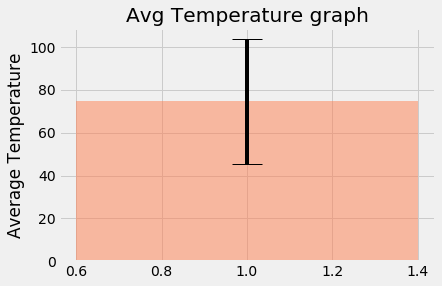

In [64]:
fig, ax = plt.subplots()
ax.bar(1, tavg, yerr = yerror,align='center',color = "coral",alpha=0.5, ecolor='black', capsize=15)
ax.set_ylabel('Average Temperature')
ax.set_title('Avg Temperature graph')
ax.yaxis.grid(True)

# Save the figure and show

plt.savefig('Trip.avg.erros.png')
plt.show()

In [65]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp)).\
    filter(Measurement.date>='2016-08-23').filter(Measurement.date<='2017-08-23').\
    filter( Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.45064024390243923),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.19894886363636372),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.14142857142857151),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.12543396226415093),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.12105095541401273),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.044818941504178235)]

## Optional Challenge Assignment

In [67]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [76]:
## Optional  calculate daily normals. Normals are the averages for the
#min, avg, and max temperatures.
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
start_date = dt.datetime.strptime("2018-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime("2018-01-10", "%Y-%m-%d")
date_range = \
    (start_date + dt.timedelta(days=x) for x in range(0, ((end_date -start_date).days)+1))


datelistmonth = []
datelistyear =[]
for date_object in date_range:
    datelistmonth.append(date_object.strftime("%m-%d"))
    datelistyear.append(date_object.strftime("%Y-%m-%d"))
    
normals =[]
for d in datelistmonth:
    normals.append(daily_normals(d)[0])
#normals    
normals   
len(datelistmonth)

10

In [77]:
# Load the previous query results into a Pandas DataFrame and 
#add the `trip_dates` range as the  `date` index
df_normal_temps = pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
df_normal_temps.index = datelistyear
df_normal_temps.index.name = 'date'


df_normal_temps

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0
2018-01-08,57.0,67.160714,75.0
2018-01-09,58.0,67.929825,78.0


<Figure size 1080x2160 with 0 Axes>

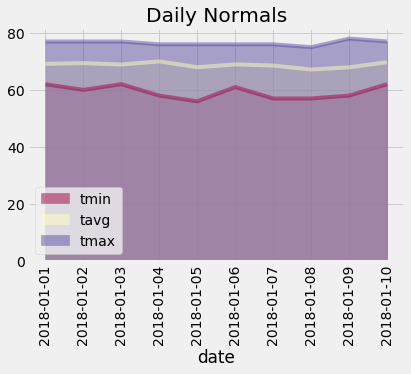

In [78]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize=(15,30))
df_normal_temps.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral',
        title='Daily Normals')
plt.xticks(np.arange(len(datelistyear)),datelistyear, rotation=90)
plt.show()